# PI7 Assignment 

## Deel 1
In dit notebook voer ik de vereiste stappen uit van de PI7-opdracht.  
Ik analyseer de SQL-database, extraheer de data naar Python, voer een uitgebreide Exploratory Data Analysis (EDA) uit en onderzoek de datakwaliteit.  
Daarnaast beschrijf ik de noodzakelijke voorbereidingen voor verdere machine-learning analyse en realiseer ik de volledige datacleaning-pipeline.

# Overzicht van de Database

Deze database bestaat uit twee tabellen die met elkaar verbonden zijn via een foreign key.

## Tabellen en Relaties

De hoofdtabellen zijn:

- **race_results**
- **riders**

De relatie tussen beide tabellen loopt via **rider_id**, welke fungeert als primary key in `riders` en als foreign key in `race_results`.


## Kolommen per Tabel

![image info](./images/ERD.png)

In de afbeelding staat ook aangegeven welk datatype elke feature heeft:
 - `A-Z`: string
 - `123`: integers/float (dit onderscheid wordt later in de notebook besproken)

### Grootte en compleetheid worden later in de notebook besproken

# Extractie van de SQL-database naar Python

In deze stap wordt de SQLite-database ingeladen in een Python-omgeving en omgezet naar pandas DataFrames. 
Dit wordt ook wel deserialisatie genoemd: de data wordt gelezen uit een persistente opslag (de .db file) en omgezet naar objecten die in het geheugen van Python gebruikt kunnen worden.

## Stappen in het conversieproces

1. Importeren van libraries  
De benodigde Python-libraries worden geïmporteerd. Hierbij wordt:
    - `sqlite3` gebruikt om verbinding te maken met de SQLite-database;

    - `os` gebruikt om het pad naar de database samen te stellen;

    - `pandas` gebruikt om SQL-tabellen om te zetten naar DataFrames;

    - `seaborn` en `matplotlib` later gebruikt voor visualisatie.

2. Opzetten van de databaseverbinding
Met behulp van sqlite3.connect() wordt een verbinding gemaakt met het databasebestand cycling_db.db, dat zich bevindt in de map data.

3. Uitlezen van tabellen
De SQL-tabellen riders en race_results worden met pd.read_sql_query() uitgelezen. Elke tabel wordt opgeslagen in een apart pandas DataFrame (df_rider en df_race_results). Hierdoor kunnen de tabellen eenvoudig geanalyseerd en gemanipuleerd worden binnen Python.

4. Sluiten van de verbinding
Na het inladen van de data wordt de databaseverbinding gesloten met conn.close(). Dit is een goede praktijk om resources vrij te geven en mogelijke locks op de database te voorkomen.

## Resultaat

Na deze stap zijn de SQL-tabellen succesvol geëxtraheerd en beschikbaar als twee afzonderlijke pandas DataFrames. Deze DataFrames vormen de basis voor verdere data-analyse, datacleaning en visualisatie in de notebook.

In [1]:
import sqlite3
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pad naar database
db_path = os.path.join("data", "cycling_db.db")
conn = sqlite3.connect(db_path)

# Lees tabellen in als DataFrame
df_rider = pd.read_sql_query("SELECT * FROM riders;", conn)
df_race_results = pd.read_sql_query("SELECT * FROM race_results;", conn)

conn.close()

Controle of `riders` tabel correct is opgeslagen als dataframe

In [2]:
df_rider.head()


,rider_id,fullname,team,birthdate,country,height,weight,rider_url,pps,rdr
0,5e4c220d0657face20e49719b725a001,BARDET Romain,Team DSM,1990-11-09,France,1.84,65.0,https://www.procyclingstats.com/rider/romain-b...,"{'One day races': '2620', 'GC': '5138', 'Time ...","{'PCS Ranking': '43', 'UCI World Ranking': '52..."
1,995d110d3b2e05830409874b401a3218,DUMOULIN Samuel,noteam,1980-08-20,France,1.59,57.0,https://www.procyclingstats.com/rider/samuel-d...,"{'One day races': '3681', 'GC': '1277', 'Time ...",{'Specials | All Time Ranking': '365'}
2,21b52056733e39f06885dfb9d18bc77a,GALLOPIN Tony,AG2R Citroën Team,1988-05-24,France,1.80,69.0,https://www.procyclingstats.com/rider/tony-gal...,"{'One day races': '2864', 'GC': '2268', 'Time ...","{'PCS Ranking': '511', 'UCI World Ranking': '9..."
3,3fe13c77eb187357fa58c810a7aa7083,NAESEN Oliver,AG2R Citroën Team,1990-09-16,Belgium,1.84,72.0,https://www.procyclingstats.com/rider/oliver-n...,"{'One day races': '3619', 'GC': '1157', 'Time ...","{'PCS Ranking': '203', 'UCI World Ranking': '1..."
4,ae00cdf6b464b193c1a34e08fe1eded7,FRANK Mathias,noteam,1986-12-09,Switzerland,1.76,64.0,https://www.procyclingstats.com/rider/mathias-...,"{'One day races': '702', 'GC': '2803', 'Time t...","{'PCS Ranking': '755', 'UCI World Ranking': '9..."


Controle of `race_results` tabel correct is opgeslagen als dataframe

In [3]:
df_race_results.head()

,id,Rnk,GC,Timelag,BiB,Rider,Age,Team,UCI,Pnt,...,Stage_Type,Start,Finish,Race_ID,Stage_Number,Length,Category,Race_url,Stage_url,rider_id
0,1,1,1.0,+0:00,0,GREIPEL André,29,Lotto Belisol Team,6.0,50.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,659ed585810c65fe22255a5e4a9b7838
1,2,2,2.0,+0:04,0,PETACCHI Alessandro,38,Lampre - ISD,4.0,30.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,None
2,3,3,4.0,+0:06,0,HUTAROVICH Yauheni,28,FDJ - BigMat,2.0,18.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,None
3,4,4,8.0,+0:10,0,SABATINI Fabio,26,Liquigas - Cannondale,1.0,13.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,13ed0fc8c2b0dcd2c4e1ac48b88166b8
4,5,5,9.0,+0:10,0,BENNATI Daniele,31,RadioShack - Nissan,1.0,10.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,c0c77a7b1a8b55d9641962ba21981cab


## Grootte en structuur van de dataset

De dataset bestaat uit twee gerelateerde tabellen: `race_results` en `riders`. Samen vormen deze tabellen een uitgebreide weergave van wielerwedstrijden en de bijbehorende renners.

## Structuur, datatypes en compleetheid van `race_results`

De tabel `race_results` bestaat uit **225.918 entries** en **25 features**, waarbij elke rij een individuele wedstrijduitslag van een renner representeert. De dataset is daardoor geschikt voor gedetailleerde analyses op renner-, etappe- en wedstrijdniveau.

### Datatypes van features

De features in deze tabel bestaan uit een mix van **numerieke** en **categorische** variabelen. Enkele kolommen, zoals `id`, `Age`, `Circuit`, `Race_ID` en `Stage_Number`, zijn opgeslagen als **integers** en lenen zich direct voor numerieke analyses.

Daarnaast zijn er meerdere kolommen met het datatype `float64`, waaronder `GC`, `UCI` en `Pnt`. Deze representeren onder andere klassementsposities en punten, maar bevatten niet voor elke observatie een waarde.

Een groot deel van de dataset bestaat uit **object-typen (strings)**, zoals `Rnk`, `Time`, `Timelag`, `Date`, `Length` en locatie- of naamgerelateerde features (`Race_Name`, `Stage_Name`, `Start`, `Finish`). Hoewel sommige van deze kolommen numerieke of temporele informatie bevatten, zijn ze momenteel als tekst opgeslagen en vereisen zij verdere preprocessing (bijvoorbeeld conversie naar numerieke waarden of datetime-objecten).

### Compleetheid van de data

De dataset is grotendeels compleet, maar bevat duidelijke verschillen in de mate van ontbrekende waarden per feature:

- Kolommen zoals `id`, `Rnk`, `Rider`, `Age`, `Time` en `Race_Name` zijn volledig gevuld.
- `GC` en `Timelag` missen waarden voor ongeveer **13%** van de observaties, wat erop wijst dat deze informatie niet voor alle renners of wedstrijdtypes beschikbaar is.
- De kolommen `UCI` en `Pnt` bevatten slechts een klein aantal niet-lege waarden, wat suggereert dat UCI-punten en wedstrijdpunten alleen voor specifieke wedstrijden of posities worden toegekend.
- `Stage_Name` en `Stage_url` ontbreken bij een deel van de data, waarschijnlijk bij eendaagse wedstrijden zonder etappestructuur.
- De foreign key `rider_id` is niet volledig gevuld, wat aandacht vereist bij het uitvoeren van joins met de `riders`-tabel.

### Conclusie

De tabel `race_results` is omvangrijk en rijk aan informatie, maar bevat meerdere features die verdere datacleaning en typeconversie vereisen. Vooral tekstuele representaties van numerieke en temporele gegevens, evenals het omgaan met ontbrekende waarden, vormen belangrijke stappen in de preprocessingfase voordat diepgaandere analyses uitgevoerd kunnen worden.


In [4]:
df_race_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225918 entries, 0 to 225917
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            225918 non-null  int64  
 1   Rnk           225918 non-null  object 
 2   GC            195498 non-null  float64
 3   Timelag       195498 non-null  object 
 4   BiB           225918 non-null  object 
 5   Rider         225918 non-null  object 
 6   Age           225918 non-null  int64  
 7   Team          225889 non-null  object 
 8   UCI           11844 non-null   float64
 9   Pnt           31760 non-null   float64
 10  Time          225918 non-null  object 
 11  Circuit       225918 non-null  int64  
 12  Race_Name     225918 non-null  object 
 13  Stage_Name    200677 non-null  object 
 14  Date          225918 non-null  object 
 15  Stage_Type    225918 non-null  object 
 16  Start         225918 non-null  object 
 17  Finish        225918 non-null  object 
 18  Race

## Missing value map - race_results

Text(0.5, 1.0, 'Missing value map')

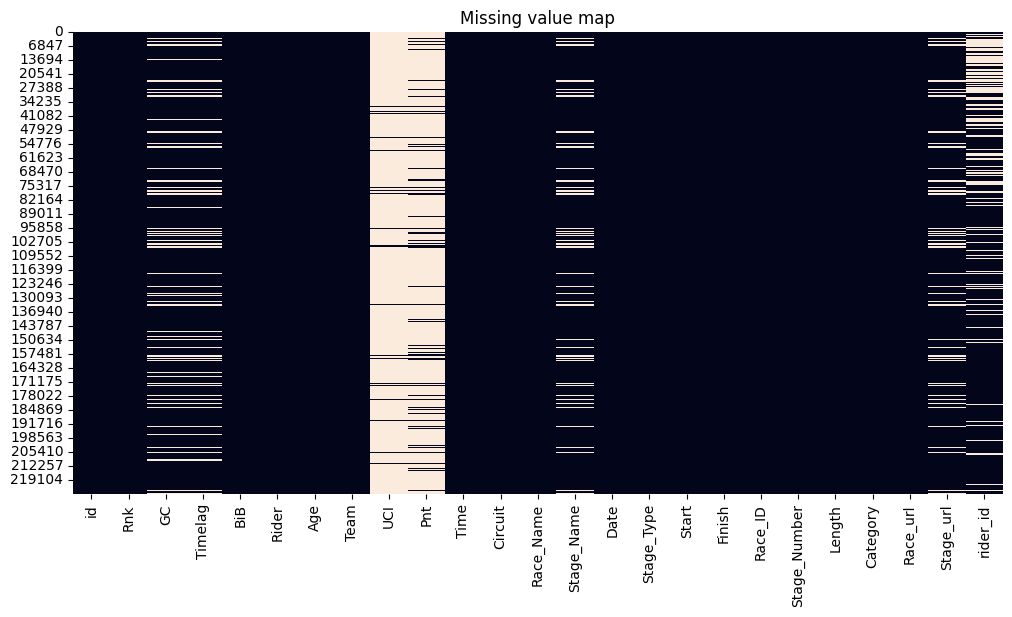

In [5]:
plt.figure(figsize=(12,6))
sns.heatmap(df_race_results.isna(), cbar=False)
plt.title("Missing value map")

## Structuur, datatypes en compleetheid van `riders`

De tabel `riders` bevat **1.042 entries** en **10 features**, waarbij elke rij één unieke renner representeert. Deze tabel fungeert als een referentietabel en wordt via de sleutel `rider_id` gekoppeld aan de tabel `race_results`.

### Datatypes van features

De meeste features in deze tabel zijn opgeslagen als **categorische variabelen** met het datatype `object`. Hieronder vallen identificerende en beschrijvende kenmerken zoals `rider_id`, `fullname`, `team`, `country` en de URL-gerelateerde kolommen (`rider_url`, `pps`, `rdr`).

De kolom `birthdate` is eveneens als `object` opgeslagen, hoewel deze in essentie een **datumvariabele** is. Voor tijdsgebonden analyses, zoals het berekenen van leeftijd op wedstrijddatum, zal deze kolom geconverteerd moeten worden naar een `datetime`-type.

Daarnaast bevat de tabel twee **numerieke features**: `height` en `weight`, beide opgeslagen als `float64`. Deze variabelen zijn geschikt voor directe statistische analyse en kunnen gebruikt worden om fysieke kenmerken van renners te onderzoeken. Bij nadere inspectie vallen echter enkele onrealistische waarden op:
- **71 renners** hebben een gewicht tussen **0 en 5 kg**.  
- **54 observaties** hebben een lengte tussen **0.0 en 0.2 meter**.  

Deze waarden suggereren dat er mogelijk fouten zijn ontstaan bij het invoeren of importeren van de gegevens. In de preprocessingfase zullen deze observaties behandeld moeten worden, bijvoorbeeld door correctie, verwijdering of markering als ontbrekende waarden (`NaN`).

### Compleetheid van de data

In tegenstelling tot `race_results` is de tabel `riders` **volledig gevuld** voor alle features, wat de tabel bijzonder geschikt maakt als stabiele bron van achtergrondinformatie bij het verrijken van de wedstrijduitslagen via joins.

### Conclusie

De tabel `riders` is compact en overzichtelijk, met vrijwel volledig ingevulde gegevens. De belangrijkste aandachtspunten voor preprocessing zijn:
- Het converteren van datumvelden (`birthdate`) naar het juiste datatype;  
- Het standaardiseren van categorische waarden;  
- Het aanpakken van onrealistische waarden bij `height` en `weight`.  

Samen met de grotere en complexere tabel `race_results` vormt `riders` een solide basis voor verdere relationele en statistische analyses.


In [6]:
df_rider.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rider_id   1042 non-null   object 
 1   fullname   1042 non-null   object 
 2   team       1042 non-null   object 
 3   birthdate  1042 non-null   object 
 4   country    1042 non-null   object 
 5   height     1042 non-null   float64
 6   weight     1042 non-null   float64
 7   rider_url  1042 non-null   object 
 8   pps        1042 non-null   object 
 9   rdr        1042 non-null   object 
dtypes: float64(2), object(8)
memory usage: 81.5+ KB


## Missing value map - riders

Text(0.5, 1.0, 'Missing value map')

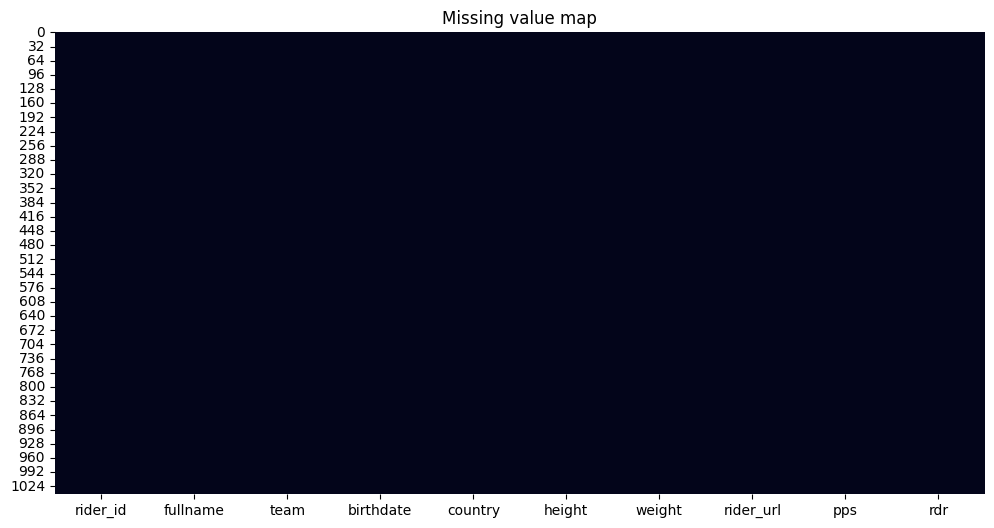

In [7]:
plt.figure(figsize=(12,6))
sns.heatmap(df_rider.isna(), cbar=False)
plt.title("Missing value map")

De kolom Rnk bleek zowel numerieke rankings als speciale statuscodes te bevatten. Waarden zoals DNF, DNS, OTL en DSQ representeren renners die niet gefinisht zijn. Daarnaast worden sommige statuscodes numeriek gecodeerd, zoals 990, 1000, 1005, 1006 en 1007. Deze waarden vertegenwoordigen geen geldige wedstrijdresultaten en zijn daarom verwijderd.

Vervolgens zijn alle overblijvende rankingwaarden opgeschoond door whitespace te verwijderen en om te zetten naar numeriek. Enkel renners met een geldige finishpositie (Rnk < 990) zijn behouden voor verdere analyses.

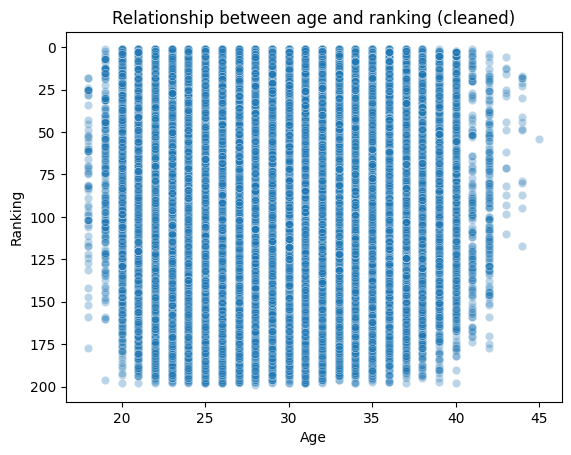

In [8]:
df_race_results["Rnk_clean"] = (
    df_race_results["Rnk"]
    .astype(str)
    .str.replace("\xa0", "", regex=False)
    .str.strip()
)

invalid_text = ["DNF", "DNS", "OTL", "DSQ"]
df_race_results.loc[
    df_race_results["Rnk_clean"].isin(invalid_text),
    "Rnk_clean"
] = None

df_race_results["Rnk_num"] = pd.to_numeric(df_race_results["Rnk_clean"], errors="coerce")

df_clean = df_race_results[df_race_results["Rnk_num"] < 990]

sns.scatterplot(data=df_clean, x="Age", y="Rnk_num", alpha=0.3)
plt.gca().invert_yaxis()  # Rank 1 bovenaan
plt.title("Relationship between age and ranking (cleaned)")
plt.xlabel("Age")
plt.ylabel("Ranking")
plt.show()

count    225918.000000
mean         28.298936
std           4.270149
min          18.000000
25%          25.000000
50%          28.000000
75%          31.000000
max          45.000000
Name: Age, dtype: float64


Text(0.5, 1.0, 'Age distribution of riders')

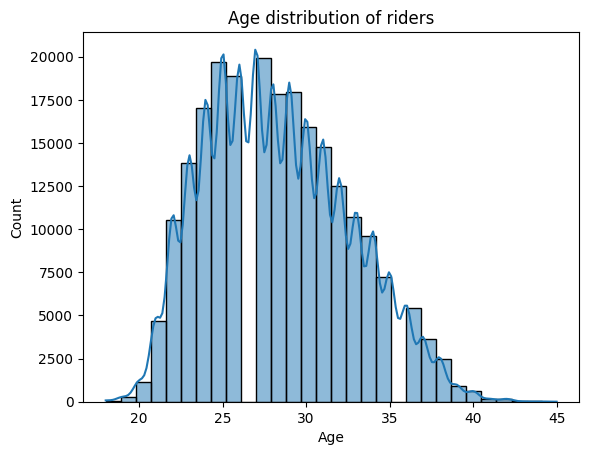

In [9]:
print(df_race_results["Age"].describe())
sns.histplot(data=df_race_results, x="Age", bins=30, kde=True)
plt.title("Age distribution of riders")
